# Zebrafish Trajectory Analysis Script

This script analyzes the movement of zebrafish in a 12-well plate experiment. It reads trajectory data, preprocesses it, calculates velocities, performs statistical analysis, and generates visualizations.
## 1. Imports and Constants

This section imports necessary libraries and defines constants for the experimental setup.

**Explanation:**

*   **Libraries:** Imports the pandas library for data manipulation, matplotlib for plotting, numpy for numerical calculations, seaborn for statistical visualizations, and scipy.stats for statistical tests.
*   **Constants:** Defines key parameters such as frames per second (`FPS`), tank dimensions (`TANK_WIDTH_CM`, `TANK_HEIGHT_CM`), video resolution (`RESOLUTION_WIDTH`, `RESOLUTION_HEIGHT`), number of fish (`NUM_FISH`), image DPI (`DPI`).
*   **Fish Name Mapping:** Defines a dictionary `fish_name_mapping` to assign names to each fish, including duplicates.

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [169]:
# Constants
FPS = 30
TANK_WIDTH_CM = 3
TANK_HEIGHT_CM = 3
RESOLUTION_WIDTH = 1800
RESOLUTION_HEIGHT = 2200
NUM_FISH = 12
DPI = 600  # for saving figures

In [170]:
# Fish name mapping
fish_name_mapping = {
    1: 'Pos Control',
    2: 'Pos Control',
    3: 'Neg Control',
    4: 'Pos Control',
    5: 'Neg Control',
    6: 'Neg Control',
    7: 'Test',
    8: 'Neg Control',
    9: 'Neg Control',
    10: 'Neg Control',
    11: 'Pos Control',
    12: 'Test'
}

## 2. Data Loading and Preprocessing

This section loads the trajectory data from a CSV file and preprocesses it.
**Explanation:**

*   **Load Data:** Reads the `trajectories.csv` file into a pandas DataFrame named `df`.
*   **Interpolation:** Fills missing data points (NaN) in the DataFrame using linear interpolation with a polynomial of order 3.  This smooths the data.
*   **Time Column:** Creates a new column named `time` representing the time in seconds for each frame based on the DataFrame index and the frame rate (`FPS`).

In [171]:
# Load the data
df = pd.read_csv('trajectories.csv')

In [172]:
# Data Preprocessing
df.interpolate(method='linear', order=3, inplace=True)  # interpolate values
df['time'] = df.index / FPS  # Add a time column in seconds

## 3. Pixel to Centimeter Conversion

This section defines a function to convert pixel coordinates to real-world centimeters.

**Explanation:**

*   **`pixel_to_cm(x, y)` Function:**  Takes `x` and `y` pixel coordinates as input and returns the corresponding centimeter coordinates based on the tank's dimensions and video resolution.
*   **Coordinate Conversion:** The `pixel_to_cm` function is applied to each x, y coordinate pair (e.g., 'x1', 'y1', 'x2', 'y2', etc.) in the DataFrame using the `.apply` method. New columns are generated, such as `x1_cm`, `y1_cm` and so on to represent the positions in centimeters.

In [173]:
# Function to convert pixel coordinates to centimeters
def pixel_to_cm(x, y):
    x_cm = (x / RESOLUTION_WIDTH) * TANK_WIDTH_CM
    y_cm = (y / RESOLUTION_HEIGHT) * TANK_HEIGHT_CM
    return x_cm, y_cm

In [174]:
# Convert all coordinates to centimeters and add as new columns
for i in range(1, NUM_FISH + 1):
    df[f'x{i}_cm'], df[f'y{i}_cm'] = zip(*df.apply(lambda row: pixel_to_cm(row[f'x{i}'], row[f'y{i}']), axis=1))

## 4. Defining Wells and Normalizing Trajectories

This section defines the well locations and removes data outside the wells.

**Explanation:**

*   **Well Centers and Radius:** Defines a dictionary `well_centers` to hold the (x, y) coordinates of the centers of each well, and `well_radius` represents the pixel radius of a well.
*   **`is_inside_well` Function:**  Takes a point (x, y), a well center, and a radius as inputs. It returns `True` if the point is inside the circle defined by the well, `False` otherwise.
*   **Data Normalization:**
    *   A copy of the original DataFrame is made and called `df_normalized`.
    *   It then iterates through the fish and apply the `is_inside_well` function using the respective well center. If a position of a fish is located outside of its well, the x, y coordinates in `df_normalized` are converted to `NaN`, effectively removing them.

In [175]:
# Define the approximate well centers and radius
well_centers = {
    1: (944, 1889), 2: (1551, 1894), 3: (333, 1886), 4: (1559, 1369),
    5: (950, 1356), 6: (350, 1363), 7: (1570, 838), 8: (365, 830),
    9: (961, 828), 10: (959, 317), 11: (342, 270), 12: (1566, 314)
}
well_radius = 225  # Adjust based on actual pixel size

In [176]:
# Function to check if a point is inside a circular well
def is_inside_well(x, y, well_center, well_radius):
    xc, yc = well_center
    return (x - xc)**2 + (y - yc)**2 <= well_radius**2

In [177]:
# Create a copy of the dataframe, and remove all the points outside the designated well.
df_normalized = df.copy()

In [178]:
# Iterate over all fish and mark points outside their respective well as NaN
for i in range(1, 13):
    x_col = f'x{i}'
    y_col = f'y{i}'
    
    well_center = well_centers[i]
    
    # Apply function to detect outliers and set them to NaN
    mask_outside = ~df_normalized.apply(lambda row: is_inside_well(row[x_col], row[y_col], well_center, well_radius), axis=1)
    df_normalized.loc[mask_outside, [x_col, y_col]] = np.nan

## 5. Analysis Function

This section defines a function to analyze the zebrafish trajectories within a given time range.
**Explanation:**

*   **`analyze_zebrafish(start_time, end_time)` Function:**  The core analysis logic is encapsulated within this function. It takes `start_time` and `end_time` parameters to control the analysis window.
*   **Combined Trajectory Plot:** Creates a plot with trajectories of all fish in one plot, with labels from the `fish_name_mapping`.
*   **Separate Density Plots:** Each fish now has its own separate density plot, and the filenames are saved using the `fish_name_mapping` and an identifier `i`.
*    **Statistical Tests:** Performs an ANOVA and Kruskal-Wallis test using all of the data points in the selected range.
*   **CSV Saving:** The results of all statistical tests, distances, and speed data are saved to distinct CSV files using Pandas DataFrames and the specified naming convention.

In [179]:
# Print to check which names were actually used.
print(f"Using the following names: {fish_name_mapping}")

Using the following names: {1: 'Pos Control', 2: 'Pos Control', 3: 'Neg Control', 4: 'Pos Control', 5: 'Neg Control', 6: 'Neg Control', 7: 'Test', 8: 'Neg Control', 9: 'Neg Control', 10: 'Neg Control', 11: 'Pos Control', 12: 'Test'}


In [180]:
def analyze_zebrafish(start_time, end_time):
    # Calculate time range for analysis
    TIME_RANGE_START = start_time
    TIME_RANGE_END = end_time

    # Filter data for specified time range
    df_time_range = df[(df['time'] >= TIME_RANGE_START) & (df['time'] <= TIME_RANGE_END)].copy()

    # 1. Combined Trajectory Plot
    plt.figure(figsize=(8, 10))
    for i in range(1, NUM_FISH + 1):
        x_col = f'x{i}'
        y_col = f'y{i}'
        label = fish_name_mapping[i]
        plt.plot(df_normalized[x_col], df_normalized[y_col], label=label, alpha = 0.7)
    plt.title('Trajectories of All Zebrafish', fontweight='bold', fontsize=20)
    plt.xlabel('X Coordinates (pixels)')
    plt.ylabel('Y Coordinates (pixels)')
    plt.legend(loc='upper right')
    plt.grid(False)
    plt.savefig(f'trajectories_all_{TIME_RANGE_START}_{TIME_RANGE_END}.png', dpi=DPI)
    #plt.show()

    # Individual Density Plots
    for i in range(1, NUM_FISH + 1):
        plt.figure(figsize=(5, 5))
        x_col = f'x{i}'
        y_col = f'y{i}'
        sns.kdeplot(x=df_normalized[x_col].dropna(), y=df_normalized[y_col].dropna(), cmap='viridis', fill=True, levels=5, alpha = 0.8)
        plt.title(f'Density Plot for {fish_name_mapping[i]}')
        plt.xlabel('X Coordinates (pixels)')
        plt.ylabel('Y Coordinates (pixels)')
        plt.savefig(f'density_{fish_name_mapping[i]}_{i}_{TIME_RANGE_START}_{TIME_RANGE_END}.png', dpi=DPI)
        #plt.show()

    # 2. Distance Travelled
    def calculate_distance_travelled(df, fish_num):
        dx = df[f'x{fish_num}_cm'].diff()
        dy = df[f'y{fish_num}_cm'].diff()
        return np.sqrt(dx**2 + dy**2).sum()
    
    distances = [calculate_distance_travelled(df_time_range, i) for i in range(1, NUM_FISH + 1)]
    
    # Creating labels with fish names and their identifiers for the Distance Plot
    labels_with_ids = [f'{fish_name_mapping[i]} {i}' for i in range(1, NUM_FISH + 1)]
    
    plt.figure(figsize=(12, 6))
    plt.bar(labels_with_ids, distances)
    plt.xlabel('Fish')
    plt.ylabel('Total Distance Travelled (cm)')
    plt.title(f'Total Distance Travelled by Each Fish ({TIME_RANGE_START}s to {TIME_RANGE_END}s)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'distance_{TIME_RANGE_START}_{TIME_RANGE_END}.png', dpi=DPI)
    #plt.show()
    
    # 3. Individual Speed Plots
    for i in range(1, NUM_FISH + 1):
      df_time_range[f'speed{i}'] = np.sqrt(df_time_range[f'x{i}_cm'].diff()**2 + df_time_range[f'y{i}_cm'].diff()**2) / \
                                       df_time_range['time'].diff()
    
    for i in range(1, NUM_FISH + 1):
        plt.figure(figsize=(8, 6))
        plt.plot(df_time_range['time'], df_time_range[f'speed{i}'], label=fish_name_mapping[i])
        plt.xlabel('Time (s)')
        plt.ylabel('Speed (cm/s)')
        plt.title(f'Speed of {fish_name_mapping[i]}')
        plt.grid(True)
        plt.savefig(f'speed_{fish_name_mapping[i]}_{i}_{TIME_RANGE_START}_{TIME_RANGE_END}.png', dpi=DPI)
        #plt.show()
    
  # 4. Combined Violin Plot
    df_speed = df_time_range[[f'speed{i}' for i in range(1, NUM_FISH+1)]].copy()
    # Create a mapping of column names to fish names and to their numbers
    speed_col_to_name = {f'speed{i}': f'{fish_name_mapping[i]} {i}' for i in range(1, NUM_FISH + 1)}
    
    # Rename the columns with both the name and the number.
    df_speed.rename(columns = speed_col_to_name, inplace = True)
    
    df_melt = df_speed.melt(var_name='Fish', value_name='Velocity')
    
    # Change the "Fish" variable in df_melt to the numbers.
    df_melt['Fish_id'] = df_melt['Fish'].apply(lambda x: x.split(" ")[0]) #Modified here.
    
    # Add the full label
    df_melt['Fish_label'] = df_melt['Fish']

    plt.rcParams['font.family'] = 'Times New Roman'
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='Fish_label', y='Velocity', data=df_melt, palette='Paired', hue='Fish_label', legend=False) #Modified here.
    plt.xticks(fontsize=16, rotation=45, ha='right')
    plt.yticks(fontsize=16)
    plt.title(f'Velocity Distribution of All Fish ({TIME_RANGE_START}s to {TIME_RANGE_END}s)', fontsize=24, fontweight='bold')
    plt.xlabel('Fish', fontsize=20, fontweight='bold')
    plt.ylabel('Speed (cm/s)', fontsize=20, fontweight='bold')
    plt.grid(False)
    plt.ylim(-0.5, 5)  # Set y-axis limit to -5 to 5
    plt.savefig(f'violin_velocity_all_{TIME_RANGE_START}_{TIME_RANGE_END}.png', dpi=DPI, bbox_inches='tight')
    #plt.show()

    # 5. Statistical Tests (Combined Data)
    velocities = [df_time_range[f'speed{i}'].dropna() for i in range(1, NUM_FISH + 1)]
    
    # Remove any empty lists of velocities
    velocities = [vel for vel in velocities if not vel.empty]

    # Statistical Tests for Distances
    stats_results_dist = {}
    if len(distances) >= 2:
        f_value_dist, p_value_dist = stats.f_oneway(*distances)
        stats_results_dist['ANOVA F-value'] = f_value_dist
        stats_results_dist['ANOVA p-value'] = p_value_dist
        print(f'ANOVA F-value (Distance): {f_value_dist}, p-value: {p_value_dist}')
    else:
         print("ANOVA on distance not performed: Less than two fish available.")

    if len(distances) >= 2:
        kruskal_h_dist, kruskal_p_dist = stats.kruskal(*distances)
        stats_results_dist['Kruskal-Wallis H-statistic'] = kruskal_h_dist
        stats_results_dist['Kruskal-Wallis p-value'] = kruskal_p_dist
        print(f'Kruskal-Wallis H-statistic (Distance): {kruskal_h_dist}, p-value: {kruskal_p_dist}')
    else:
         print("Kruskal-Wallis on distance not performed: Less than two fish available.")

    stats_df_dist = pd.DataFrame([stats_results_dist])
    stats_df_dist.to_csv(f'stats_distances_{TIME_RANGE_START}_{TIME_RANGE_END}.csv', index=False)

    # Statistical Tests for Velocities
    stats_results_vel = {}
    if len(velocities) >= 2:
       f_value_vel, p_value_vel = stats.f_oneway(*velocities)
       stats_results_vel['ANOVA F-value'] = f_value_vel
       stats_results_vel['ANOVA p-value'] = p_value_vel
       print(f'ANOVA F-value (Velocity): {f_value_vel}, p-value: {p_value_vel}')
    else:
       print("ANOVA on velocity not performed: Less than two fish available.")
    if len(velocities) >= 2:
        kruskal_h_vel, kruskal_p_vel = stats.kruskal(*velocities)
        stats_results_vel['Kruskal-Wallis H-statistic'] = kruskal_h_vel
        stats_results_vel['Kruskal-Wallis p-value'] = kruskal_p_vel
        print(f'Kruskal-Wallis H-statistic (Velocity): {kruskal_h_vel}, p-value: {kruskal_p_vel}')
    else:
      print("Kruskal-Wallis on velocity not performed: Less than two fish available.")

    stats_df_vel = pd.DataFrame([stats_results_vel])
    stats_df_vel.to_csv(f'stats_velocities_{TIME_RANGE_START}_{TIME_RANGE_END}.csv', index=False)
    
    # Save distance traveled data to CSV
    df_distances = pd.DataFrame({'Fish': labels_with_ids, 'Distance': distances})
    df_distances.to_csv(f'distances_{TIME_RANGE_START}_{TIME_RANGE_END}.csv', index = False)

    # Save speed data to CSV
    df_speeds = df_time_range[[f'speed{i}' for i in range(1, NUM_FISH+1)]].copy()
    df_speeds.rename(columns = {f'speed{i}': fish_name_mapping[i] for i in range(1, NUM_FISH+1)}, inplace = True)
    df_speeds.to_csv(f'speeds_{TIME_RANGE_START}_{TIME_RANGE_END}.csv', index=False)

    # Print summary statistics
    print(f"Summary Statistics ({TIME_RANGE_START}s to {TIME_RANGE_END}s):")
    print(f"Total frames: {len(df_time_range)}")
    print(f"Analyzed time: {df_time_range['time'].max() - df_time_range['time'].min():.2f} seconds")
    print("\nDistance Travelled:")
    for i, dist in enumerate(distances, 1):
        print(f"{labels_with_ids[i-1]}: {dist:.2f} cm")
    print("\nAverage Speed:")
    for i in range(1, NUM_FISH + 1):
       print(f"{fish_name_mapping[i]}: {df_time_range[f'speed{i}'].mean():.2f} cm/s")

## 6. Calling the Analysis Function

This section calls the analysis function with the specified parameters.
**Explanation:**

*   Sets the values for start and end time, and calls the `analyze_zebrafish` function with those parameters.

*  Run the script using `Run All` button at `Top` of this notebook.


C:\Users\shamshad\AppData\Local\Temp\ipykernel_22000\3209438976.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))
c:\Users\shamshad\miniconda3\envs\idtrackerai\Lib\site-packages\scipy\stats\_axis_nan_policy.py:567: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
C:\Users\shamshad\AppData\Local\Temp\ipykernel_22000\3209438976.py:110: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_value_dist, p_value_dist = stats.f_oneway(*distances)


ANOVA F-value (Distance): nan, p-value: nan
Kruskal-Wallis H-statistic (Distance): 11.0, p-value: 0.4432632784264654
ANOVA F-value (Velocity): 53.05530526270902, p-value: 1.4035417973824207e-117
Kruskal-Wallis H-statistic (Velocity): 3498.5794608101105, p-value: 0.0
Summary Statistics (0s to 200s):
Total frames: 6000
Analyzed time: 199.97 seconds

Distance Travelled:
Pos Control 1: 19.67 cm
Pos Control 2: 39.11 cm
Neg Control 3: 29.12 cm
Pos Control 4: 29.50 cm
Neg Control 5: 35.20 cm
Neg Control 6: 37.57 cm
Test 7: 18.57 cm
Neg Control 8: 43.80 cm
Neg Control 9: 37.60 cm
Neg Control 10: 18.07 cm
Pos Control 11: 31.24 cm
Test 12: 20.32 cm

Average Speed:
Pos Control: 0.10 cm/s
Pos Control: 0.20 cm/s
Neg Control: 0.15 cm/s
Pos Control: 0.15 cm/s
Neg Control: 0.18 cm/s
Neg Control: 0.19 cm/s
Test: 0.09 cm/s
Neg Control: 0.22 cm/s
Neg Control: 0.19 cm/s
Neg Control: 0.09 cm/s
Pos Control: 0.16 cm/s
Test: 0.10 cm/s


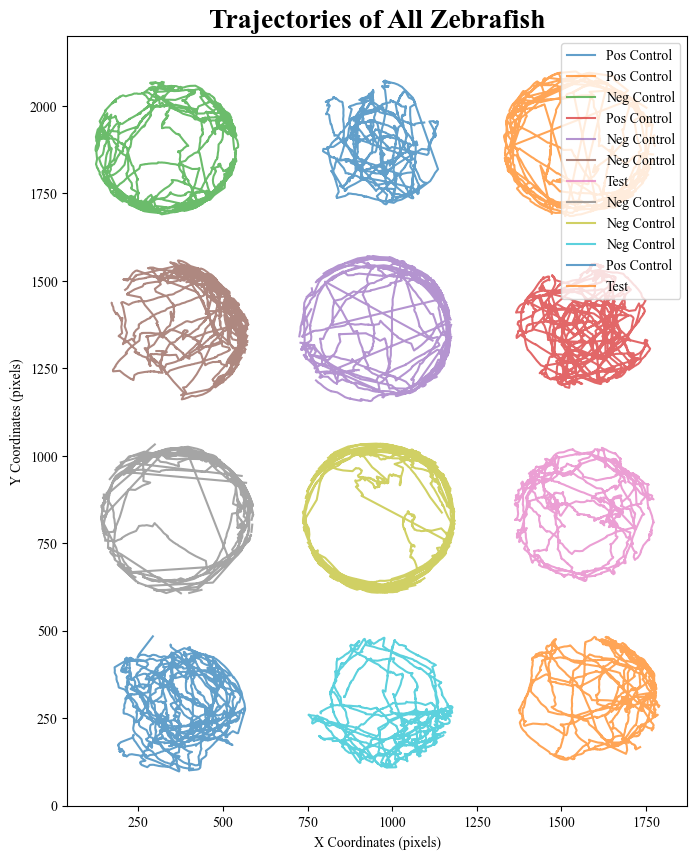

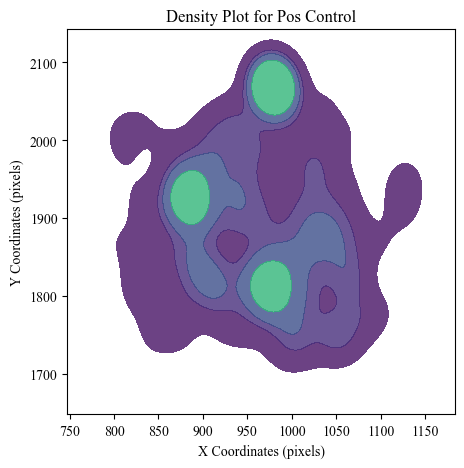

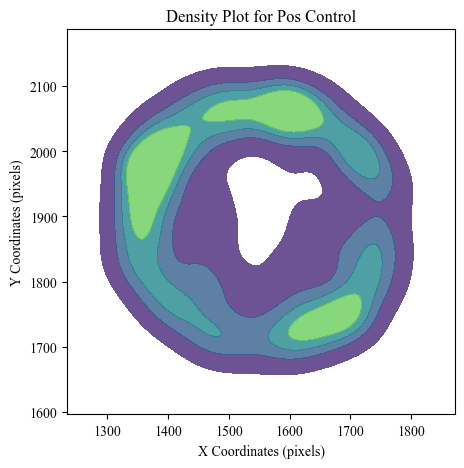

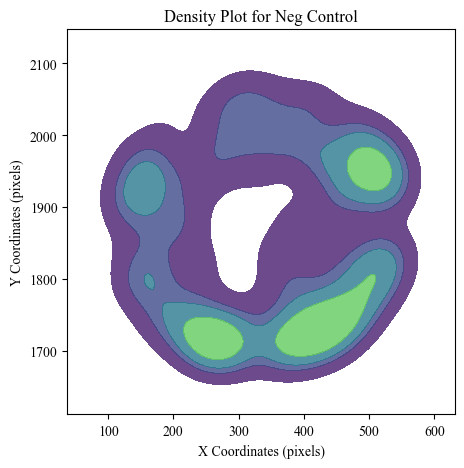

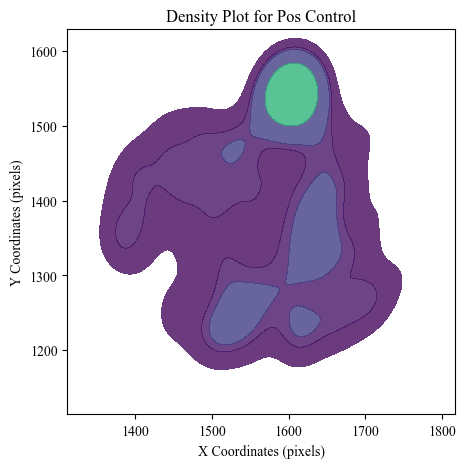

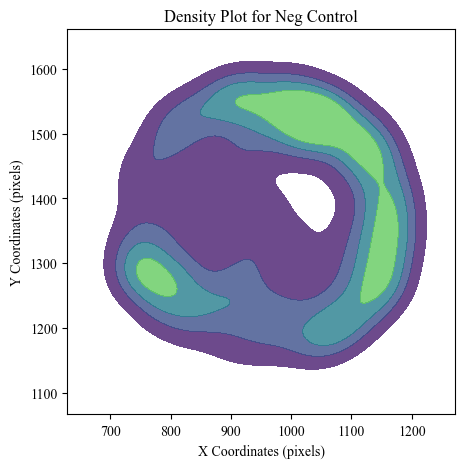

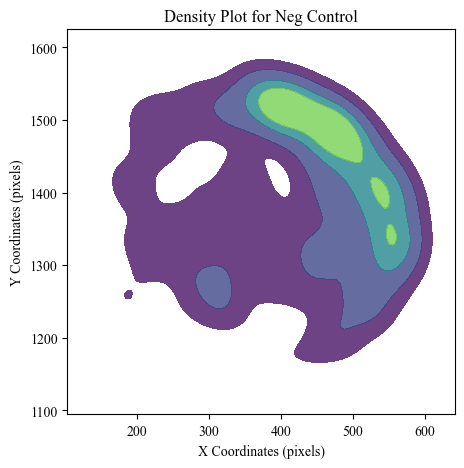

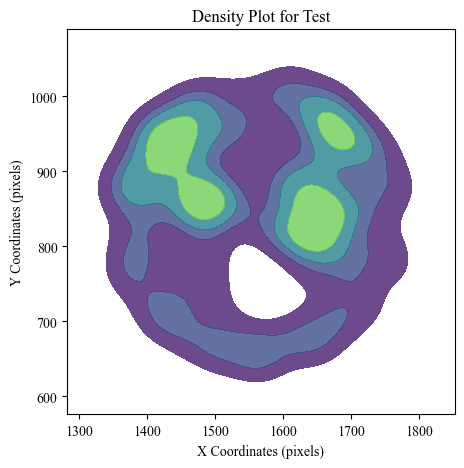

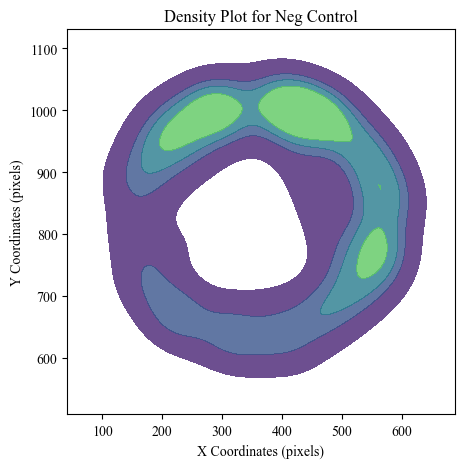

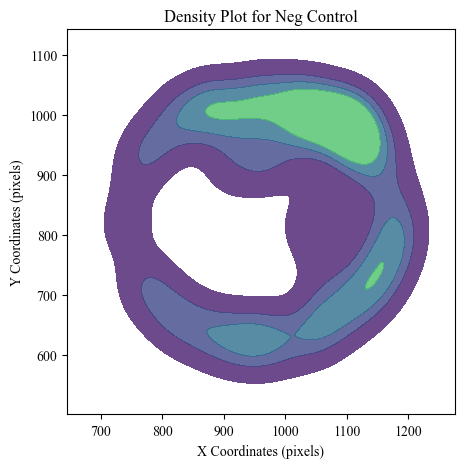

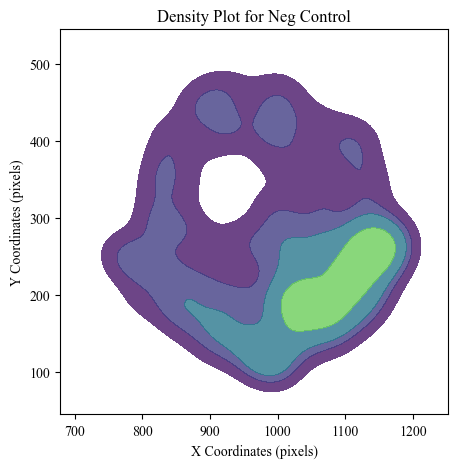

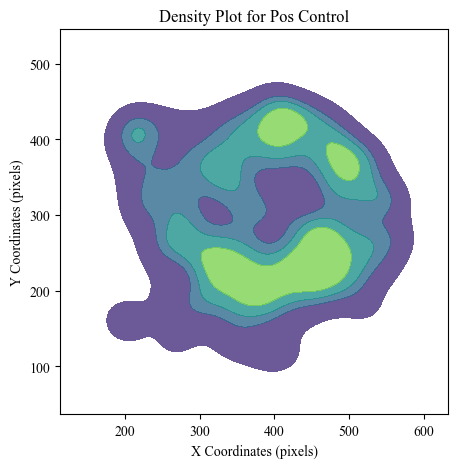

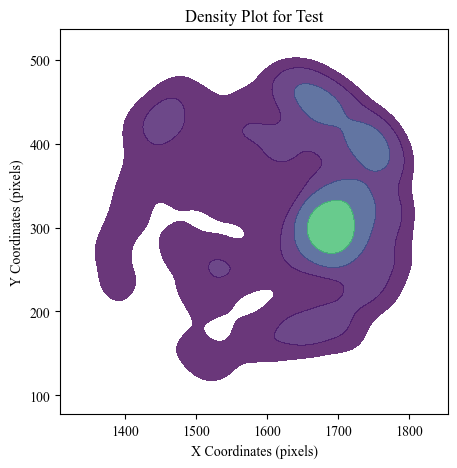

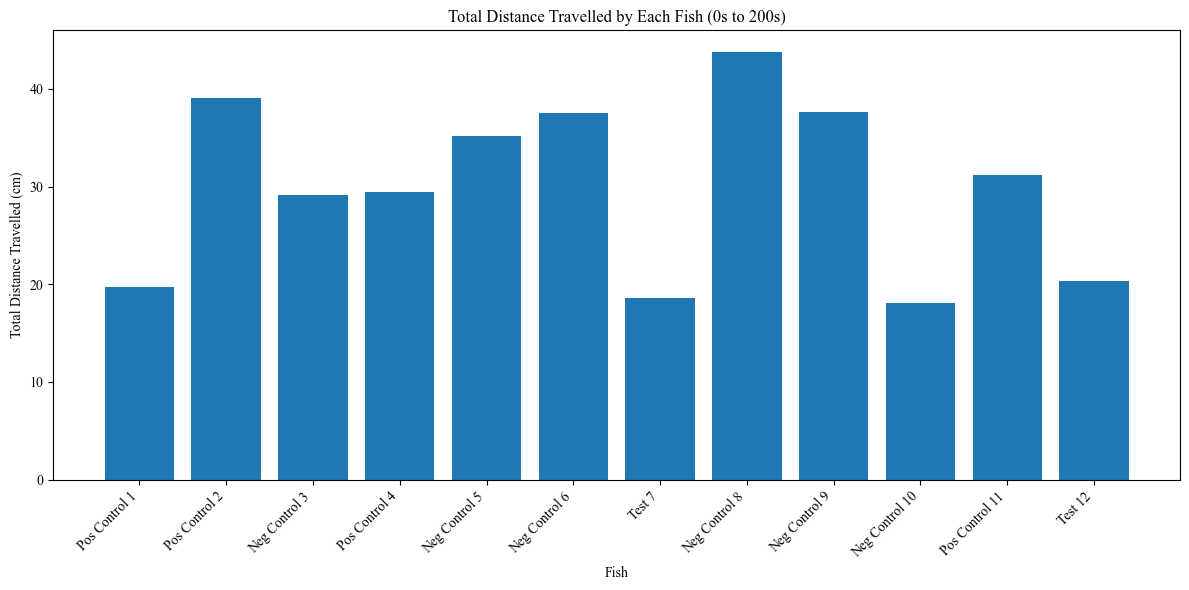

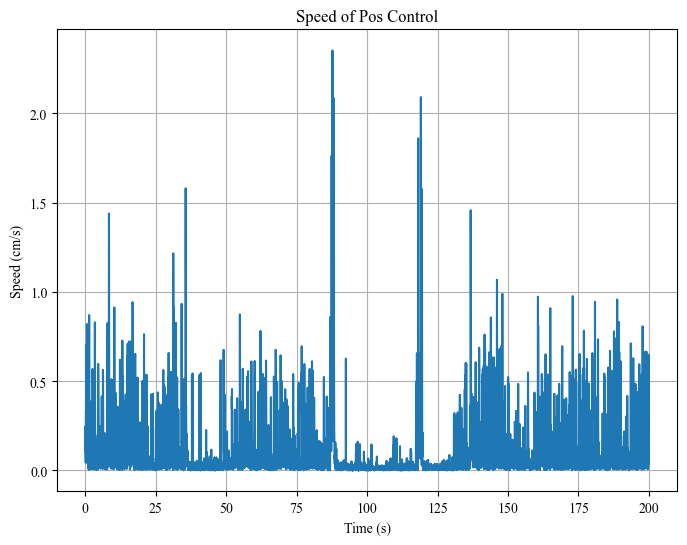

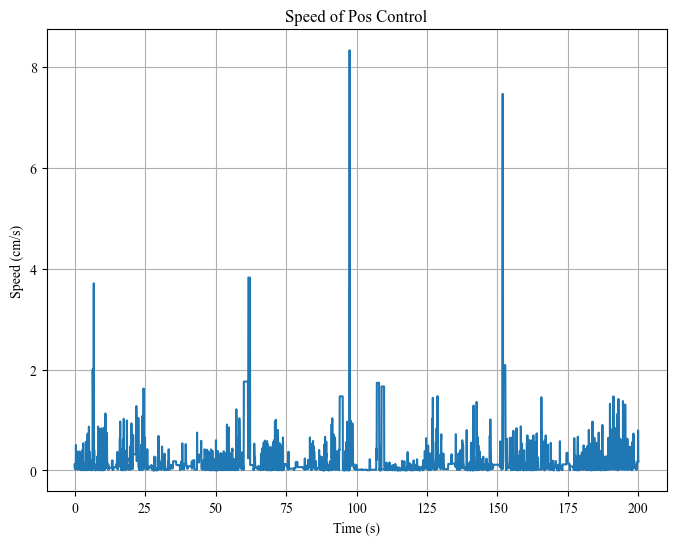

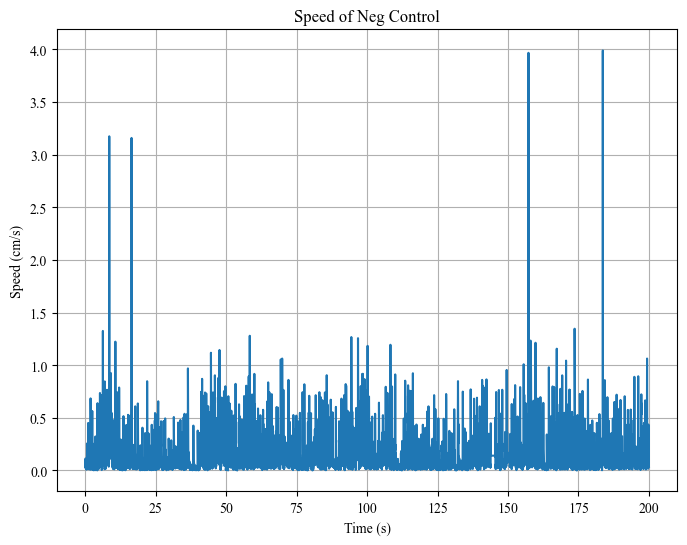

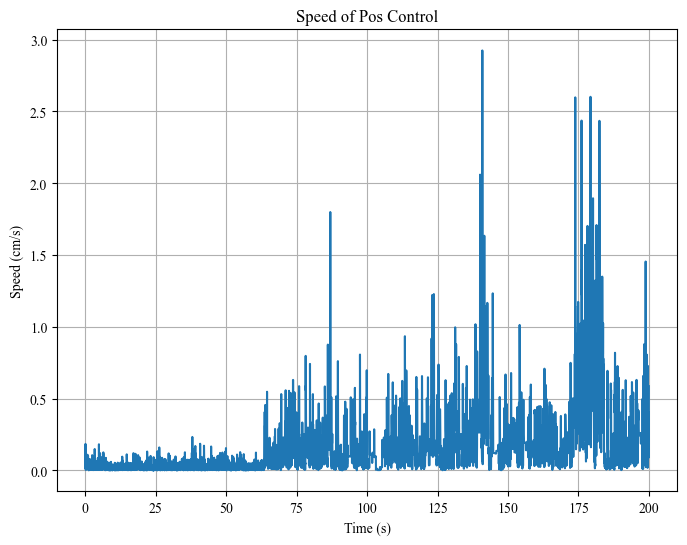

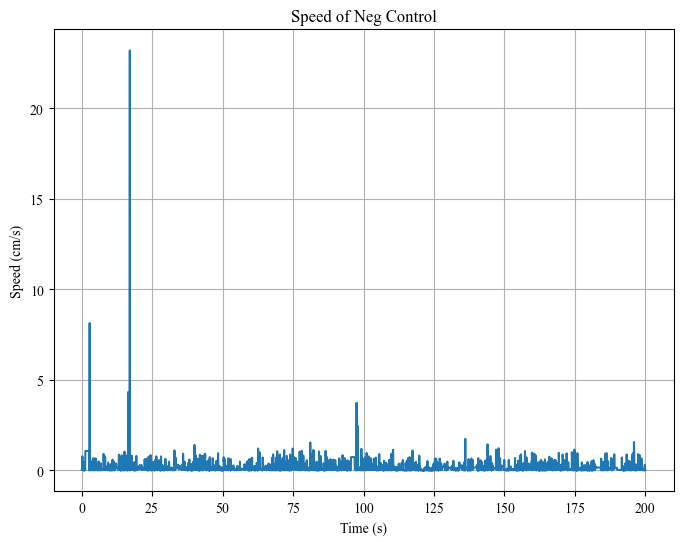

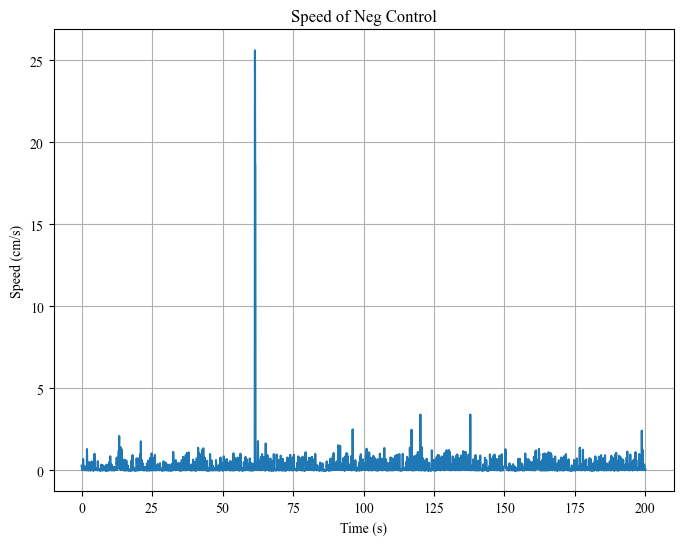

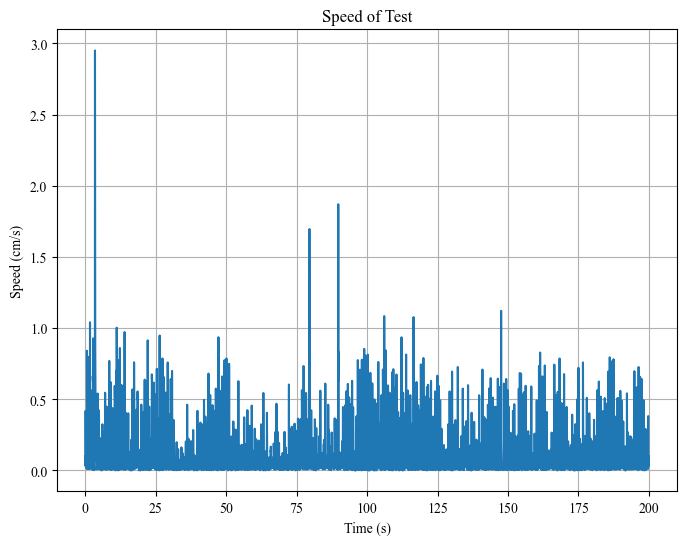

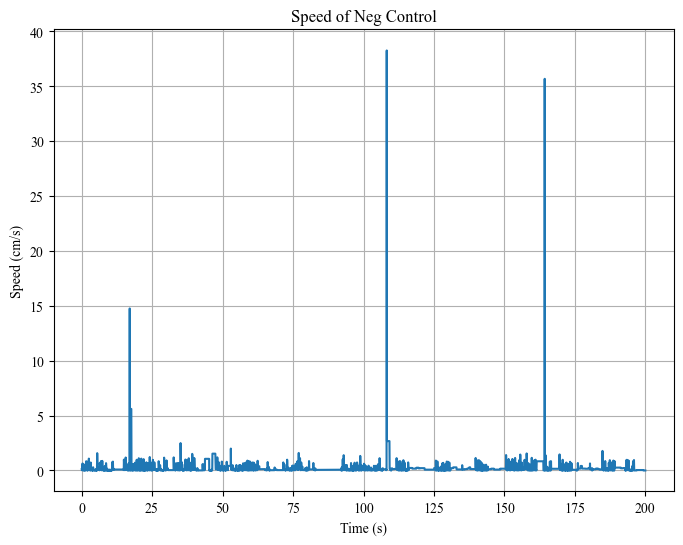

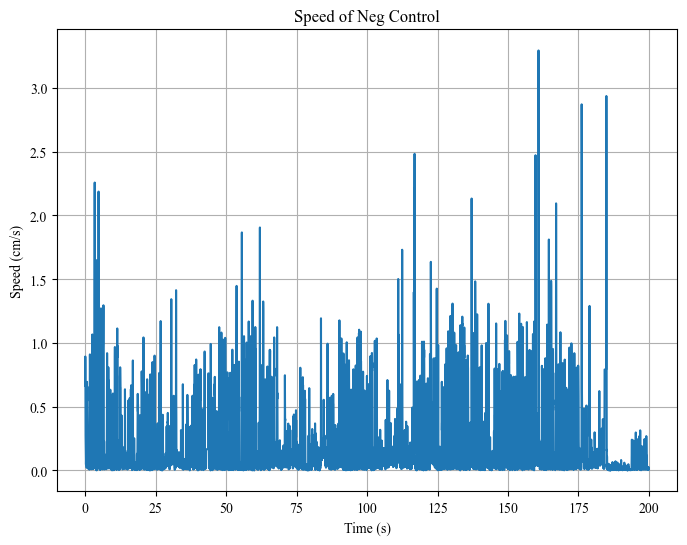

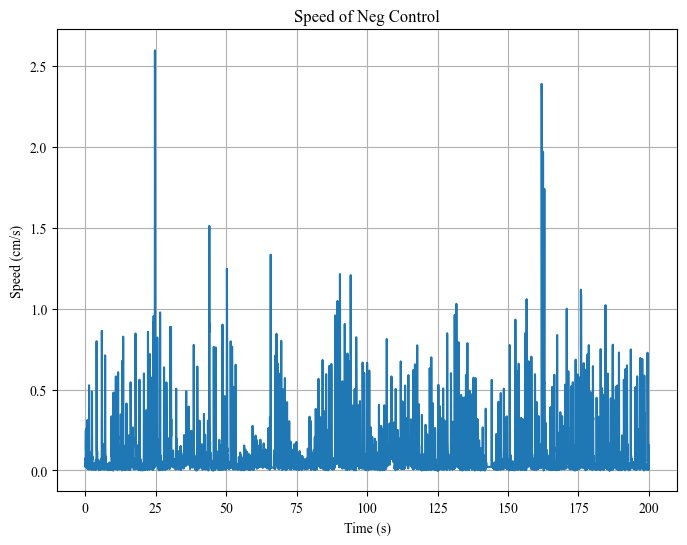

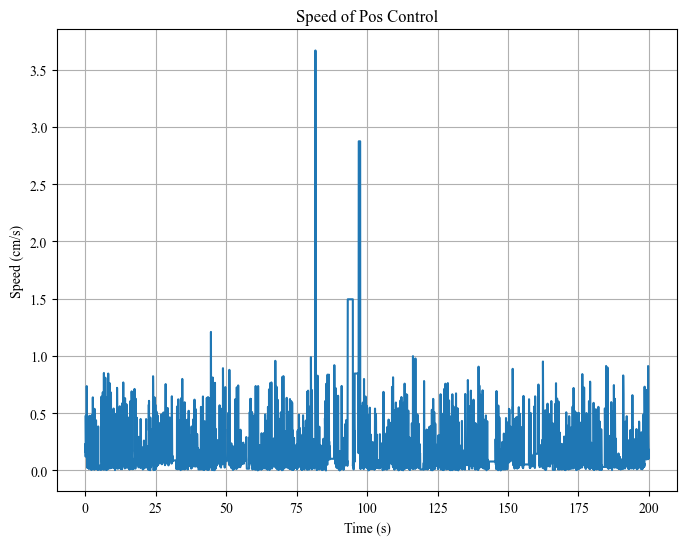

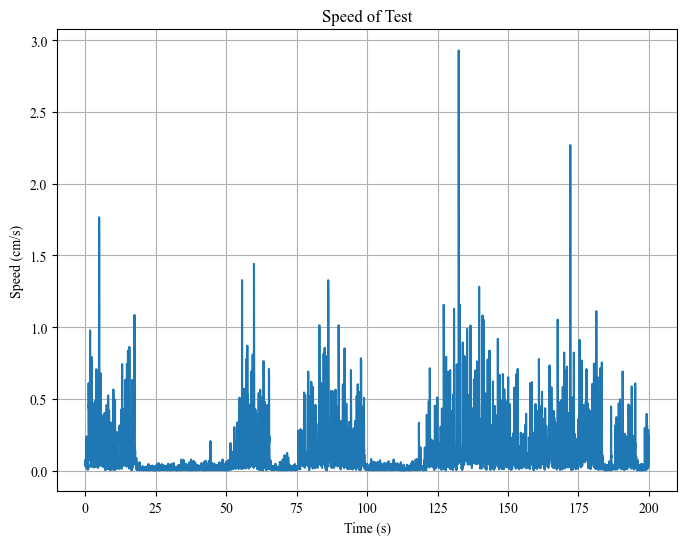

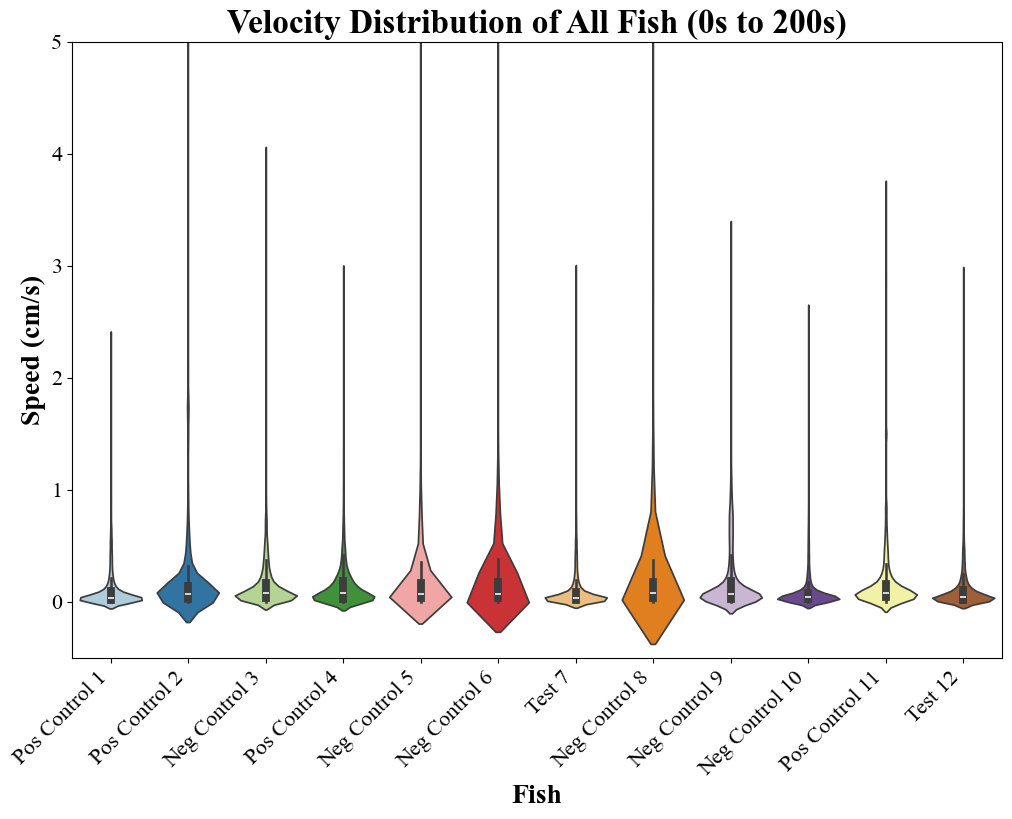

In [181]:
# Get analysis range from user (can be hardcoded for testing)
analysis_start_time = 0  # Start time in seconds
analysis_end_time = 200  # End time in seconds
analyze_zebrafish(analysis_start_time, analysis_end_time)